# Optimize effective interactions for Se-Te segregation in bulk Fe$_x$Se$_{1-x}$Te

1. Import raw target data (atomic configurations obtained from image analysis, etc.)
2. Select an initial set of descriptors (histograms of configurations to match)
3. Select an initial model (e.g., zero interactions)
4. and generate first reference data for a set of models
5. Calculate statistics from the generated data
    * statistics relevant for a given interaction model (e.g., numbers of nearest neighbors for total energy)
    * statistics of properties to be matched with target (e.g., histograms of local configurations)
6. Perform optimization by minimizing statistical distance between target and model properties
7. Write new parameters into MC simulation input files
8. Run simulation with the optimized model to verify predictions based on the perturbation technique

### Notebook setup

In [2]:
# basic libraries
import os, sys
import re
import copy
from itertools import product, permutations, combinations, combinations_with_replacement
from collections import Counter
import numpy as np
import scipy.io
from scipy.optimize import fmin

# plotting
%matplotlib inline
import matplotlib.pyplot as plt

# data handling
# import pyUSID as usid
# import h5py
#import pandas as pd
#import xarray as xr

# parallelization
from subprocess import Popen, PIPE
import multiprocessing as mp

In [3]:
# local library
sys.path.append('../../../force_fields/statmechlib')
from statmechlib.read_write import read_lattice_model, read_modeldef, write_modeldef
from statmechlib.preprocessing import get_stats_latt
from statmechlib.forcefields import sd2

In [4]:
# code development settings (automatically reload modified modules)
%load_ext autoreload
%autoreload 2

In [5]:
# project directories
data_raw = '../data/raw'
src_dir = '../src'
sim_dir = '../sim'

## 1. Import target data

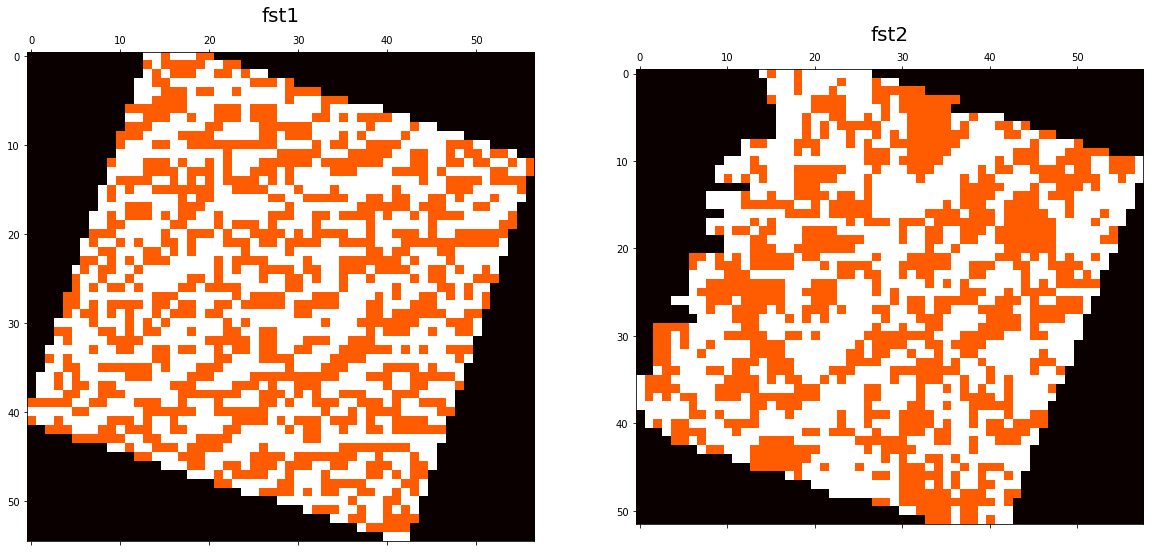

In [99]:
# load matlab file with data
image_names = ['fst1', 'fst2']

ncols = 2
nrows = len(image_names) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,10))

images = {}
for i, name in enumerate(image_names):
    mm = scipy.io.loadmat(os.path.join(data_raw, name+'.mat'))
    images[name] = np.array(mm['map'])
    
    ir, ic = divmod(i, ncols)
    if nrows == 1:
        axes[ic].matshow(images[name], cmap = 'hot')
        axes[ic].set_title(name, fontsize=20)
    else:
        axes[ir, ic].matshow(images[name], cmap = 'hot')
        axes[ir, ic].set_title(name, fontsize=20)    

**Data augmentation**

* generate new 'artificial' images by (i) splitting existing image into fragments and (ii) imposing symmetries corresponding to rotating and reflecting the image fragments
    1. rotating the original image by 0, 90, 180, and 270 degrees.
    2. flipping it along x, y, xy, and -xy directions
    * Together they cover all 8 possible combinations of x and y axes with + and - signs
* this will facilitate grouping configurations based on rotational symmetry

In [102]:
# split images to subsections (4x4)
nx = 8
ny = 8
images_split = {}

for name, config in images.items():
    lx = config.shape[0]
    ly = config.shape[1]
    dx = lx//nx
    dy = ly//ny
    for x, y in product(range(nx), range(ny)):
        namexy = name + '_' + str(x) + '_' + str(y)
        xmin = dx*x ; xmax = dx*(x+1)
        ymin = dy*y ; ymax = dy*(y+1)
        config_cut = config[xmin:xmax, ymin:ymax]
        images_split[namexy] = config_cut

In [103]:
len(images_split.keys())

128

In [104]:
# generate artificial images by applying symmetry transformations

target_set = {}

# cycle over original image configurations
for name, config in images_split.items():
    target_set[name] = []

    # rotate the image by 0, 90, 180, and 270 degrees
    # and flip the image along x, y, xy, and -xy axes: 8 transformations in total

    for a1, a2 in permutations([0, 1]): # choose axis order (x, y) or (y, x)
        
        # shape of the tranformed image
        lx = config.shape[a1]
        ly = config.shape[a2]

        for s1, s2 in product([1, -1], repeat=2): # set signs of the two axes
            
            config_transformed = np.zeros((lx, ly), dtype=int)

            # set shifts so that the tranformed array starts at 0 indices
            x_shift = 0 if s1 > 0 else lx - 1
            y_shift = 0 if s2 > 0 else ly - 1
            
            for x, y in product(range(config.shape[0]), range(config.shape[1])):
            
                # transform coordinates
                x_new = s1*x if a1==0 else s1*y
                y_new = s2*y if a1==0 else s2*x
                
                # apply shifts to fit in a numpy array
                x_new += x_shift
                y_new += y_shift
                
                config_transformed[x_new, y_new] = config[x, y]

            target_set[name].append(config_transformed)

In [105]:
# show all image fragments
ncols = 8
nrows = sum([len(t) for t in target_set.values()])// ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5*nrows))

images = {}
i = 0
for name, target in target_set.items():
    for j, config in enumerate(target):
        ir, ic = divmod(i, ncols)
        i += 1
        axes[ir, ic].matshow(config, cmap = 'hot')

fig.tight_layout()

## 2. Collect histograms of selected local configurations

### 2.1 Generate sets of descriptors

1. Systematically build configurational descriptors by expanding distance from a central particle NN, NNN, ...
2. After collecting histograms, determine symmetries using NMF clustering with stat distance. Do they correspond to physical symmetries?
3. Initially assume translational invariance, but later consider distinguishing x, y coordinates and test the symmetry like all other symmetries. Use statistical hypothesis testing to determine the presence of symmetries

Note: can we translate this procedure to neural networks (capsule, graph)?

In [107]:
# Structural descriptors

# Define a list of absolute {x, y} distances that cover all possible configurations
# within two lattice sites in x and y directions.
# There are 2**13 possible configurations in this space.
# Obviously, there will not be enough data to get reasonable statistics for each configuration,
# but it can allow us testing different descriptors and the effect of their coarse-graining

neighbor_distances = [(0, 0), (0, 1), (1, 1), (0, 2)]

neighbor_types = []
for nbr in neighbor_distances:

    # create a list of neibhbor coordinates
    nbr_list = set()
    for i, j in permutations(nbr):
        nbr_list.add(( i,  j))
        nbr_list.add((-i,  j))
        nbr_list.add(( i, -j))
        nbr_list.add((-i, -j))

    neighbor_types.append(tuple(sorted(nbr_list)))

print('Neighbor coordinates:')
for nn in neighbor_types:
    print(nn)

Neighbor coordinates:
((0, 0),)
((-1, 0), (0, -1), (0, 1), (1, 0))
((-1, -1), (-1, 1), (1, -1), (1, 1))
((-2, 0), (0, -2), (0, 2), (2, 0))


In [108]:
# list of per image local configurations

target_data = {}

# cycle over original image configurations
for name, conf_list in target_set.items():
    target_data[name] = []

    # list of local configurations obtained from an image
    hhh = []
    
    # cycle over symmetry-related configurations based on a given image
    for mp in conf_list:
    
        # cycle over lattice sites
        for i, j in product(range(mp.shape[0]), range(mp.shape[1])):

            # configuration identifier
            cfg = []
        
            # cycle over different types of neighbors (self, nn, nnn, etc.)
            for neighbors in neighbor_types:

                # cycle over neighboring sites of a given type
                nb = []
                for ki, kj in neighbors:

                    if i+ki < 0 or i+ki >= mp.shape[0]:
                        nb.append(-1)
                        continue
                    if j+kj < 0 or j+kj >= mp.shape[1]:
                        nb.append(-1)
                        continue

                    # atom type
                    tt = mp[i+ki, j+kj]

                    nb.append(tt)
                
                cfg.append(tuple(nb))

            # list of configuration IDs
            hhh.append(tuple(cfg)) 
    
    # dict of image configurations
    target_data[name] = hhh

In [111]:
# print a sample of configuration ID
target_data[list(target_data.keys())[10]][50]

((1,), (1, 1, 0, 1), (1, 1, 0, 1), (-1, -1, 1, 0))

In [112]:
# filter out configurations involving invalid sites (outside image) denoted as -1
# not really used later. coarse graining takes care of this
conf_clean = []
for name, stats in target_data.items():
    conf_clean.append([t for t in stats if -1 not in t[0]+t[1]+t[2]+t[3]])

## 3. Coarse grain into 'reasonable' histogram statistics

### 3.1. Coarse-grain by grouping larger configurations with the same near-neighbor configurations

In [113]:
# Create a list of all possible configurations
def get_all_configs(degree=1):

    nums = 1 + 4*degree
    
    cfg_all = set()
    for c in product([0,1], repeat=nums):
        cfg = [(c[0],)]
        for i in range(0, degree):
            cfg += [tuple(c[1+i*4:5+i*4])]
        cfg_all.add(tuple(cfg))

    return cfg_all

In [114]:
def coarse_grain(conf, degree=1, clean=True):
    """
    Group configurations that are same within a given extent of the neighborhood
    of the central particle (e.g., nn, nnn, etc.).
    
    Parameters
    ----------
    conf: list
          list of fine-grained configurations
    degree: int
          degree of neighborhood. Default 1 == nearest neighbors
    clean: bool
          eliminate configurations containing out of image lattice sites. Default: True
          
    Returns
    -------
    conf_cg: list
            list of coarse-grained configurations
    """

    conf_cg = []

    for t in conf:
        c = []
        for i in range(degree+1):
            if clean and (-1 in t[i]):
                break
            c.append(t[i])
        else:
            conf_cg.append(tuple(c))

    return conf_cg

In [122]:
# filter out configurations involving invalid sites (outside image) denoted as -1

degree = 1

# find a set of all possible configurations of a given degree
cfg_all = get_all_configs(degree)
print(len(cfg_all), type(cfg_all))

conf_cg = {}
hist_cg = {}
for name, stats in target_data.items():
    
    # select configurations of a given degree of coarse graining
    conf_cg[name] = coarse_grain(stats, degree=degree)
    
    if len(conf_cg[name]) == 0:
        del conf_cg[name]
        continue

    # collect histogram in the form of a dict
    hist_cg[name] = Counter(conf_cg[name])
    #print('Number of distinct configurations in image', name, ':', len(hist_cg[name]))
    print(len(hist_cg[name]), end=' ')

    
    # Add the missing configurations and set their counts to 0
    for key in cfg_all:
        if key not in hist_cg[name]:
            hist_cg[name][key] = 0
    
    # order configurations in an image by their counts
    confs_ordered = [(t[1], t[0]) for t in sorted(hist_cg[name].items(), key=lambda x: x[-1], reverse=True)]
    
#     # print 5 configurations with highest counts for each image
#     print('Most frequent configurations in image', name, ':')
#     for j in range(1):#range(len(confs_ordered)):
#         print(j, 'count:', confs_ordered[j][0], '; configuration:', confs_ordered[j][1])
print('\nNumber of nonzero histograms:', len(hist_cg))

32 <class 'set'>
27 23 4 20 24 22 27 30 13 24 23 24 16 17 28 30 30 25 28 29 25 24 16 8 30 28 29 26 24 28 14 19 29 24 28 21 29 16 28 20 23 25 27 26 28 16 29 26 25 29 21 15 27 17 4 29 29 25 17 23 9 9 30 19 13 18 27 22 26 26 26 24 22 28 14 23 29 22 26 27 24 10 19 26 18 27 24 19 23 23 30 28 19 22 26 17 5 13 14 30 26 5 
Number of nonzero histograms: 102


**Plot configuration histograms for different images**

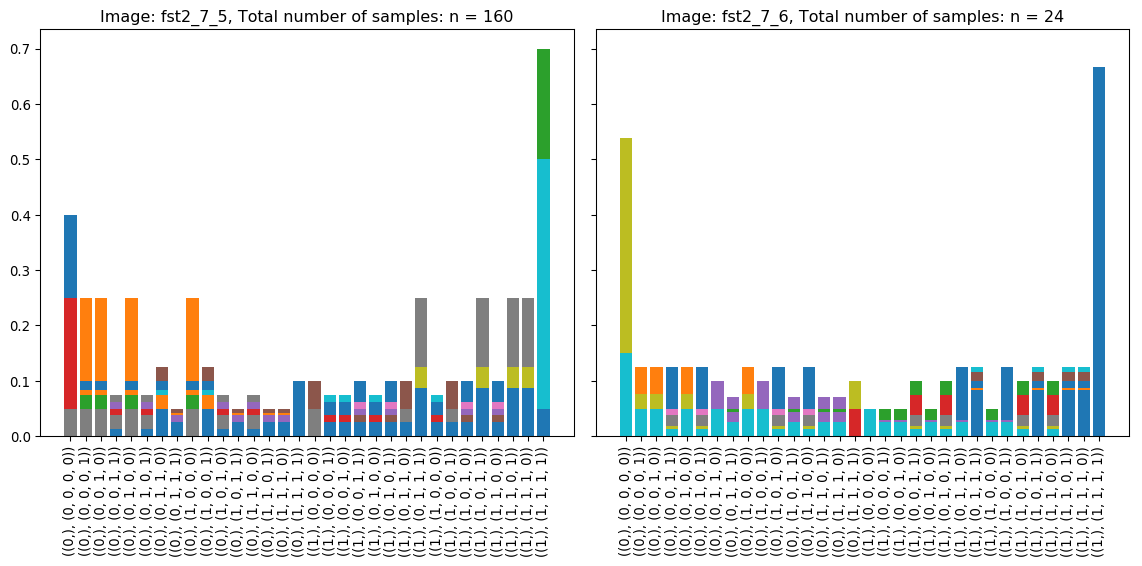

In [161]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(12, 6), dpi = 96)

num_samples = {}
for i, (name, hist) in enumerate(hist_cg.items()):
    cfg_labels = [str(key) for key in sorted(hist.keys())]
    #counts = target_hist[name]
    all_counts = np.array([hist[cfg] for cfg in sorted(hist.keys())])
    #print(len(cfg_labels), len(all_counts))
    n_sample = np.sum(all_counts)
    #num_samples[name] = n_sample
    all_counts = all_counts/float(n_sample)

    ir, ic = divmod(i, 2)
    axs[ic].bar(cfg_labels, all_counts)
    axs[ic].set_xticklabels(cfg_labels, rotation=90.0)
    axs[ic].set_title('Image: ' + name + ', Total number of samples: n = ' + str(n_sample))
    #axs[ic].set_ylim(0,0.01)
    
plt.tight_layout()
plt.show()

### 3.2. Further coarse-grain by grouping symmetry related configurations
#### 3.2.1 Try to determine symmetry using NMF-based clustering in the probability space

* In this case only rotational and reflective symmetries can be expected to hold absolutely (because of the data augmentation)

* Other groupings may be suggested, but more independent images would be helpful.

* Output can provide p-values for the presence of a symmetry.

* For sparse matrices with zero counts in many histogram bins, the zeros should be replaced by the best estimates of the actual values (as opposed to maximum likelihood estimates that would set them to zero)

In [124]:
# for name, hist in hist_cg.items():
#     print(len([hist[cfg] for cfg in sorted(hist.keys())]))

(102, 32)
Components: 1  loss: 0.048811944382091695
Components: 2  loss: 0.0221193191208105
Components: 3  loss: 0.01319843158308145
Components: 4  loss: 0.009060985675612265
Components: 5  loss: 0.004498704960400824
Components: 6  loss: 0.0026751335875068874
Components: 7  loss: 0.0012216177534815555
Components: 8  loss: 0.0006505306529772948
Components: 9  loss: 0.00028021226715702513
Components: 10  loss: 0.00017315512718290915
Components: 11  loss: 4.144152184116991e-05
Components: 12  loss: 2.1268308719193947e-32


Text(0.5,1,'Loss as a function of NMF components (minimum reached at n=12)')

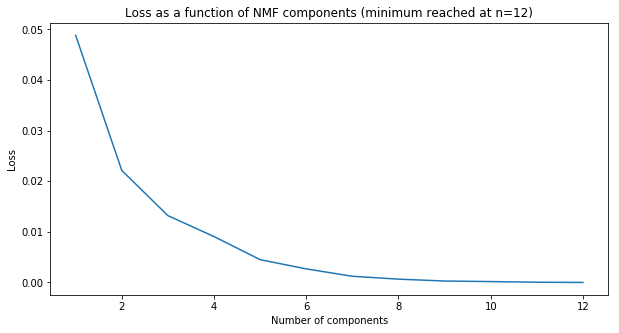

In [181]:
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error

# Create a matrix of probability vector coordinates, one vector per image statistics
X = []
for name, hist in hist_cg.items():
#     if 'fst2' in name:
#         continue
    all_counts = np.array([hist[cfg] for cfg in sorted(hist.keys())], dtype=float)
    all_counts /= np.sum(all_counts)
    #print(all_counts)
    X.append(np.sqrt(all_counts))
    
X = np.array(X)
print(X.shape)

x_comp = []
y_loss = []
for n_components in range(1, 13):
    model = NMF(n_components=n_components, init='random', max_iter=10000, tol=1e-15)#, random_state=0)
    W = model.fit_transform(X)
    H = model.components_
    Y = W.dot(H)

    loss = 0
    for x, y in zip(X, Y):
        y_norm = np.sqrt(np.sum(y**2))
        x_norm = np.sqrt(np.sum(x**2))
        loss += (1.0-(np.array(x)/x_norm).dot(np.array(y)/y_norm))**2

    loss /= len(X)
    print('Components:', n_components, ' loss:', loss)

    x_comp.append(n_components)
    y_loss.append(loss)

plt.figure(figsize=(10,5))
plt.plot(x_comp, y_loss)
plt.xlabel('Number of components')
plt.ylabel('Loss')
plt.title("Loss as a function of NMF components (minimum reached at n=12)")

Text(0.5,1,'12 components of the original 32 features')

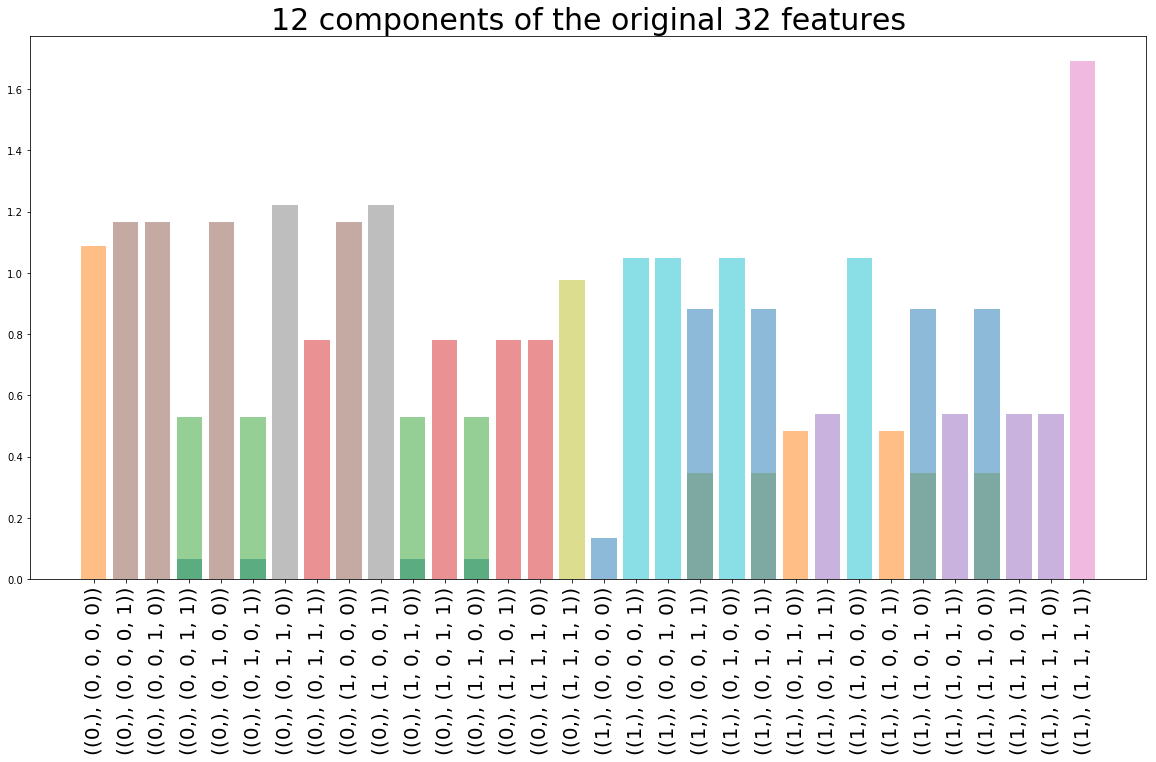

In [186]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
cfg_labels = [str(key) for key in sorted(hist.keys())]

for i, hx in enumerate(H[:]):
    axs.bar(cfg_labels, hx, alpha=0.5)

#plt.xticks(cfg_labels, rotation=90.0)
axs.set_xticklabels(cfg_labels, rotation=90.0, fontsize=20)


plt.title("12 components of the original 32 features", fontsize=30)

** Most of the 32 original configurations are represented by a single coarse-grained configuration. There are 2 cases of colinearity. **

Text(0.5,0.98,'12 components in separate plots')

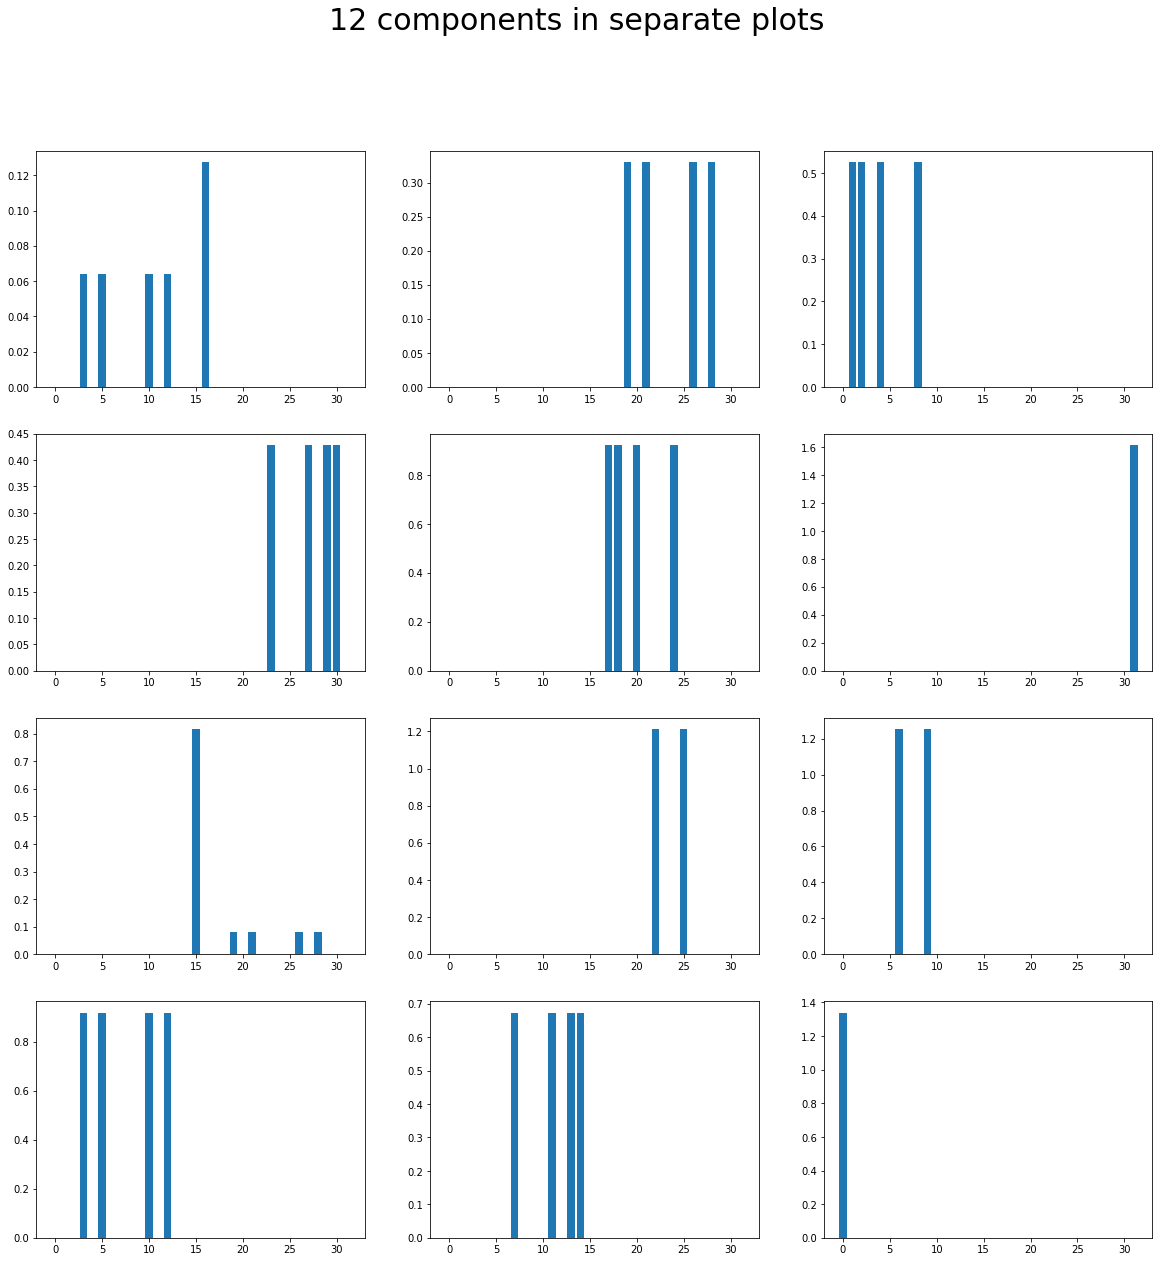

In [180]:
nrows = 4
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
for i, hx in enumerate(H):
    ir, ic = divmod(i, ncols)
    axs[ir, ic].bar(list(range(len(hx))), hx)

fig.suptitle("12 components in separate plots", fontsize=30)
#fig.tight_layout()

## 4. Optimize parameters using CG target configurations

In [15]:
from scipy.optimize import fmin

sys.path.append('../../../force_fields/statmechlib')
from statmechlib.read_write import read_lattice_model, read_modeldef, write_modeldef
from statmechlib.preprocessing import get_stats_latt
from statmechlib.forcefields import sd2

from subprocess import Popen, PIPE
import multiprocessing as mp

In [16]:
sim_dir = '../src/code'

In [17]:
# read reference system parameters into an array
def read_mld(data_paths):
    pars_ref = {}
    for data_path in data_paths:
        params = read_modeldef(os.path.join(data_path, 'lg.mld'))
        pars_ref[data_path] = np.array([v for v in params['ref_params'].values()]).flatten(order='F')

    # check if the force field parameters agree between systems
    assert len(set([str(v) for v in pars_ref.values()])) == 1, "Different parameters"

    return pars_ref[data_paths[0]]

In [18]:
# read lattice simulation results: configuration statistics and energies
def read_outputs(names, dirnames):
    trjs = {}
    for name, dname in zip(names, dirnames):
        trjs[name] = read_lattice_model(dname)
    return trjs

In [19]:
# filter the results (discard initial imin number of configurations)
def trajectory_range(trjs, imin=10):

    for key in trjs.keys():
        trjs[key]['energy'] = trjs[key]['energy'][imin:]
        trjs[key]['temp'] = trjs[key]['temp'][imin:]
        trjs[key]['interaction_stats'] = trjs[key]['interaction_stats'][imin:]
        trjs[key]['config_stats'] = trjs[key]['config_stats'][imin:]

    return trjs


In [20]:
def make_reference_histograms(trjs):
    """
    For given trajectories, convert to histograms of symmetrized configurations
    """
    # group symmetric configurations collected from a simulated system based on their unique label
    hsv = {}
    for name, trj in trjs.items():
        # convert to the histograms of symmetrized configurations
        old_hist = np.array(trj['config_stats'])
        hsv[name] = trans_hist.dot(old_hist.T).T
        # normalize = calculate relative frequencies of symmetrized configurations
        for i in range(hsv[name].shape[0]):
            sm = np.sum(hsv[name][i,:])
            hsv[name][i,:] = hsv[name][i,:]/sm

    return hsv

In [21]:
# filter the results (discard initial configurations)
def make_energy_statistics(trjs):
    hsu = {}
    for name, trj in trjs.items():
        # flatten the array column by column (Fortran style 'F')
        hsu[name] = np.array([np.array(ar).flatten(order='F') for ar in trj['interaction_stats']])
    return hsu

In [22]:
# get relative frequencies of symmetrized surface local configurations averaged over all 'image' configurations
def make_average_histograms(names):
    hsv_ave = {}
    for name in names:
        histave = []
        for i in range(hsv[name].shape[1]):
            histave.append(sum(hsv[name][:,i])/float(hsv[name].shape[0]))
        hsv_ave[name] = np.array(histave)

    return hsv_ave

In [23]:
# Assemble target data structures
def make_targets(gsv, num_samples):
    targets = {}
    for name in gsv.keys():
        # target
        targ = {}
        targ['config_stats'] = gsv[name]
        targ['weight'] = num_samples[name]/sum(num_samples.values())
        targets[name] = targ

    return targets

In [24]:
# Assemble reference data structures
def make_stats(trjs, hsu, hsv):
    stats = {}
    for name in trjs.keys():
        # reference data
        stat = {}
        stat['config_stats'] = hsv[name]
        stat['interaction_stats'] = hsu[name]
        stat['energy'] = np.array(trjs[name]['energy'])
        stat['temp'] = np.array(trjs[name]['temp'])
        stats[name] = stat

    return stats

In [25]:
gsv = {}
for i, name in enumerate(names):
    counts = target_hist[name]
    all_counts = np.array([counts.get(cfg, 0) for cfg in cfg_types])
    n_sample = np.sum(all_counts)
    all_counts = all_counts/float(n_sample)
    gsv[name] = all_counts

NameError: name 'names' is not defined

In [35]:
def optimize_params(data):#par_in, stat, target):
    par_in = data['params']
    stat = data['stats']
    target = data['targets']
    print('# Start sd2 =', sd2(par_in, stat, target))
    print('# Starting parameters:', par_in)
    output = fmin(sd2, par_in, args=(stat, target), maxiter=100000, maxfun=10000, disp=0, full_output=1)
    print('\n# End sd2 =', output[1])
    p_out = output[0]
    print('# Final parameters:', p_out)
    return p_out, output[1]

In [51]:
# define data sets for which parameters will be optimized
from itertools import combinations
# full set of systems
datasets = {0:tuple(names)}
# partial sets of systems
datasets.update({i:s for i, s in enumerate(combinations(names, 3), 1)})
datasets = {0:('re55',)}
print(datasets)

{0: ('re55',)}


In [26]:
# number of optimization iterations
n_iter = 5
for it in range(n_iter):
    
    input_data = []
    for key in range(len(datasets)):
    #for key, dset in datasets.items():
        dset = datasets[key]
        
        # directory names
        dirnames = [str(key) + '_' + s for s in dset]
        data_paths = [os.path.join(sim_dir, dname) for dname in dirnames]

        # get reference parameters
        pars_ref = read_mld(data_paths)
        pars_in = np.array([pars_ref[1], pars_ref[4]])
        
        # read reference data
        trjs = read_outputs(dset, data_paths)
        
        #pool = mp.Pool()
        #trj_list = pool.map(read_lattice_model, data_paths)
        #trjs = dict(zip(dset, trj_list))
        
        # select the equilibrated part of the trajectories
        trjs = trajectory_range(trjs, imin=1000)
        
        # get histograms of symmetrized configurations
        hsv = make_reference_histograms(trjs)

        # get statistics of for lattice model energetics
        hsu = make_energy_statistics(trjs)
        
        # make targets and statistics for optimization with selected names
        targets = make_targets(gsv, num_samples)
        stats = make_stats(trjs, hsu, hsv)
        print(stats.keys())
        
        # select statistics and targets relevant for dset 
        stats_opt = {s:stats[s] for s in dset}
        targets_opt = {s:targets[s] for s in dset}
        
        # optimize parameters
        input_data.append({'params':pars_in, 'stats':stats_opt, 'targets':targets_opt})

        #oputput_data = optimize_params(input_data)#pars_in, stats_opt, targets_opt)

    pool = mp.Pool()
    output_data = pool.map(optimize_params, input_data)

    # write model definition files with new parameters
    for key in range(len(datasets)):
        dset = datasets[0] # make parameter files for _all_ systems
        
        # directory names
        dirnames = [str(key) + '_' + s for s in dset]
        data_paths = [os.path.join(sim_dir, dname) for dname in dirnames]

        # set new parameters
        p_out = output_data[key][0]
        pars = [0., p_out[0], 0., 0., p_out[1], 0.]

        # write model definition file into a simulation directory
        for data_path in data_paths:
            write_modeldef(os.path.join(data_path, 'lg.mld'), pars)

    # run simulations
    original_dir = os.getcwd()
    # go to simulation directory
    os.chdir(sim_dir)
    
    for key in range(len(datasets)):
        dset = datasets[0] # run simulations for _all_ systems

        # directory names
        dirnames = [str(key) + '_' + s for s in dset]
    
        proc_list = []
        fout_list = []

        for name, dname in zip(dset, dirnames):
            os.chdir('./'+dname)
        
            fout = open('lg.run', 'w')
            fin = open(name+'.inp', 'r')
        
            proc_list.append(Popen('./lg', stdin=fin, stdout=fout, stderr=PIPE))
        
            fin.close()
            fout_list.append(fout) 
            os.chdir('..')

        for proc, fout in zip(proc_list, fout_list):
            proc.wait()
            fout.close()
    
    # go back to notebook directory
    os.chdir(original_dir)

NameError: name 'datasets' is not defined

0.07051797 -0.27910435

0.02054406 -0.50064873

0.06463121 -0.22251215 0.018662095932150156

0.02972088 -0.30352361 0.018200443606690948

0.10573289 -0.45494785 0.01816080620437813

In [54]:
from scipy.stats import norm

dset = datasets[0]
input_data = []

for key in ['r_', '0_']:
#for key in ['1_', '2_', '3_', '4_']:

        
    # directory names
    dirnames = [key + s for s in dset]
    data_paths = [os.path.join(sim_dir, dname) for dname in dirnames]

    # get reference parameters
    pars_ref = read_mld(data_paths)
    pars_in = np.array([pars_ref[1], pars_ref[4]])
        
    # read reference data
    trjs = read_outputs(dset, data_paths)

    #pool = mp.Pool()
    #trj_list = pool.map(read_lattice_model, data_paths)
    #trjs = dict(zip(dset, trj_list))
        
    # select the equilibrated part of the trajectories
    trjs = trajectory_range(trjs, imin=1000)
        
    # get histograms of symmetrized configurations
    hsv = make_reference_histograms(trjs)
    for key, val in hsv.items():
        print('hsv.shape', key, val.shape)
        print('n_eff:', n_effective(val))

    # get statistics of for lattice model energetics
    hsu = make_energy_statistics(trjs)
        
    # make targets and statistics for optimization with selected names
    targets = make_targets(gsv, num_samples)
    stats = make_stats(trjs, hsu, hsv)
    print(stats.keys())

    # select statistics and targets relevant for dset 
    stats_opt = {s:stats[s] for s in dset}
    targets_opt = {s:targets[s] for s in dset}
        
    # optimize parameters
    input_data.append({'params':pars_in, 'stats':stats_opt, 'targets':targets_opt})
        
    s2 = sd2(pars_in, stats_opt, targets_opt)
    print('----MODEL:', key, '-----')
    print('Total statistical distance: ', s2)
    z_coeff = np.sqrt(460.0*s2/2.0)
    print('z-coeff:', z_coeff)
    p_value = norm.sf(z_coeff)
    print('p-value:', p_value)

    for s in dset:
        stats_opt = {s:stats[s]} 
        targets_opt = {s:targets[s]}
        
        s2 = sd2(pars_in, stats_opt, targets_opt)
        print(f'Statistical distance for {s}: ', s2)
        z_coeff = np.sqrt(460.0*s2/2.0)
        print('z-coeff:', z_coeff)
        p_value = norm.sf(z_coeff)
        print('p-value:', p_value)

Reading ../src/code/r_re55/lg.hst
Reading ../src/code/r_re55/lg.run
hsv.shape re55 (39001, 26)
n_eff: 2097.8423525777343
dict_keys(['re55'])
----MODEL: re55 -----
Total statistical distance:  0.0082469666962364
z-coeff: 1.3772444736263683
p-value: 0.08421833801765571
Statistical distance for re55:  0.0082469666962364
z-coeff: 1.3772444736263683
p-value: 0.08421833801765571
Reading ../src/code/0_re55/lg.hst
Reading ../src/code/0_re55/lg.run
hsv.shape re55 (39001, 26)
n_eff: 2156.1502178957858
dict_keys(['re55'])
----MODEL: re55 -----
Total statistical distance:  0.007800196474996424
z-coeff: 1.3394197210916292
p-value: 0.09021703641186335
Statistical distance for re55:  0.007800196474996424
z-coeff: 1.3394197210916292
p-value: 0.09021703641186335


## X. Calculation of the effective number of parameters

In [27]:
def corr_cov(data_matrix, output='corr'):
    """
    Calculates correlation matrix for n_exp multinomial experiments with n samples each
    resulting in k possible states.

    Parameters
    ----------
    data_matrix: ndarray((n_exp, k), dtype=float)
                 data matrix of n_exp experiments with results in k histogram bins (states)
    output: str
            defines whether correlation ('corr' - default) or covariance ('cov') matrix is returned

    Returns
    -------
    corr_mat: ndarray((k, k), dtype=float)
            correlation matrix 
                 
    """
    
    n_exp = data_matrix.shape[0]

    # calculate averages of the columns
    averages = np.stack([np.mean(data_matrix, axis=0)]*n_exp, axis=0)
    
    # data deviations from averages
    data_centered = data_matrix - averages
    
    # calculate covariance matrix
    cov_mat = data_centered.T.dot(data_centered)/(n_exp - 1.)
    
    if output == 'cov':
        return cov_mat

    # inverse square root variance diagonal matrix
    var_srinv = np.sqrt(np.diag(1.0/np.diag(cov_mat)))

    # correlation matrix
    corr_mat = var_srinv.dot(cov_mat).dot(var_srinv)
    
    return corr_mat

In [28]:
def n_effective(data_matrix):
    """
    Calculate the effective number of samples from a data matrix of a multinomial distribution.
    Calls corr_cov function to calculate covariance matrix
    
    Parameters
    ----------
    data_matrix: ndarray((n_exp, k), dtype=float)
                 data matrix of n_exp experiments with results in k histogram bins (states)

    Returns
    -------
    n_eff: float
           effective number of samples
    """
    
    v = np.diag(corr_cov(data_matrix, output='cov'))
    p = np.mean(data_matrix, axis=0)
    
    # vector of effective sample numbers for each histogram bin
    n_eff_vec = p*(1-p)/v
    
    # mean value (should it be minimum value?)
    n_eff = np.mean(n_eff_vec)
    #n_eff = np.min(n_eff_vec)
    
    return n_eff

In [29]:
mat = np.random.multinomial(m, hist, (d_img,))/m

hist2 = np.copy(hist)
hist2[0:k//2] = hist2[0:k//2]+0.01
hist2[k//2:] = hist2[k//2:]-0.01
print(hist2)
mat2 = np.random.multinomial(m, hist2, (d_img//2,))/m

hist3 = np.copy(hist)
hist3[0:k//2] = hist3[0:k//2]-0.01
hist3[k//2:] = hist3[k//2:]+0.01
print(hist3)
mat3 = np.random.multinomial(m, hist3, (d_img//2,))/m

ave = np.stack([np.mean(mat, axis=0)]*d_img, axis=0)
ave2 = np.stack([np.mean(mat2, axis=0)]*d_img, axis=0)
ave3 = np.stack([np.mean(mat3, axis=0)]*d_img, axis=0)

mat23 = np.concatenate((mat2, mat3))

n_effective(mat)

v = np.diag(corr_cov(mat23, output='cov'))
p = np.mean(mat23, axis=0)
n_eff = p*(1-p)/v
np.mean(n_eff)

NameError: name 'm' is not defined